In [95]:
import math, re , os
import tensorflow as tf
import json
import cv2
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from functools import partial 
from sklearn.model_selection import train_test_split
print("tensorflow version" + tf.__version__)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers

tensorflow version2.3.0


In [34]:
IMAGE_SIZE = [512 , 512]
def decode_image(image):
    image = tf.image.decode_jpeg(image , channels = 3)
    image = tf.cast(image , tf.float32)/255.0
    image = tf.reshape(image , [*IMAGE_SIZE , 3])
    return image

In [35]:
BASE_DIR = "Downloads/cassava-leaf-disease-classification/"

In [36]:
with open(os.path.join(BASE_DIR, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}
    
print(json.dumps(map_classes, indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [37]:
input_files = os.listdir(os.path.join(BASE_DIR, "train_images"))
print(f"Number of train images: {len(input_files)}")

Number of train images: 21397


In [48]:
# shape of 1st 300 images
img_shapes = {}
for image_name in os.listdir(os.path.join(BASE_DIR, "train_images"))[:300]:
    image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_name))
    img_shapes[image.shape] = img_shapes.get(image.shape, 0) + 1 

print(img_shapes)

{(600, 800, 3): 300}


In [59]:
df_train = pd.read_csv(os.path.join(BASE_DIR , "train.csv"))
df_train["class_name"] = df_train["label"].map(map_classes)

df_train[:10]

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)
5,1000837476.jpg,3,Cassava Mosaic Disease (CMD)
6,1000910826.jpg,2,Cassava Green Mottle (CGM)
7,1001320321.jpg,0,Cassava Bacterial Blight (CBB)
8,1001723730.jpg,4,Healthy
9,1001742395.jpg,3,Cassava Mosaic Disease (CMD)


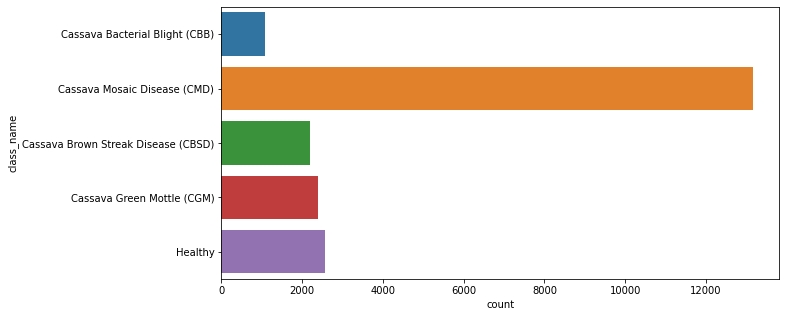

In [64]:
plt.figure(figsize=(10, 5))
sn.countplot(y="class_name", data=df_train);

In [65]:
def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

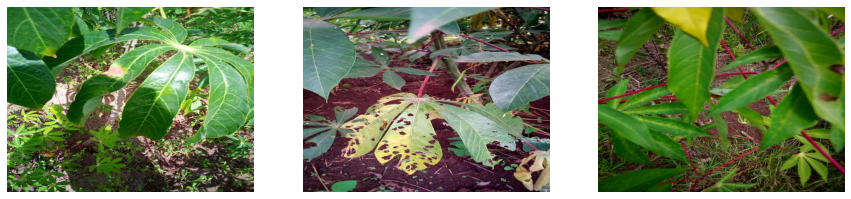

In [84]:
sample = df_train[df_train.label == 0].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

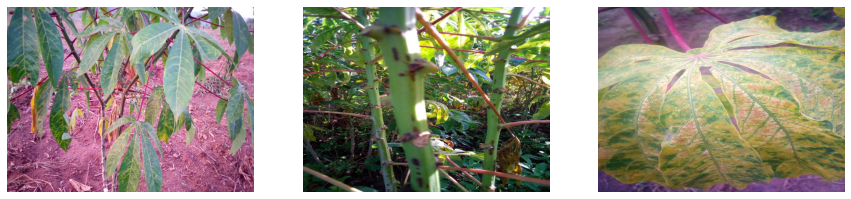

In [72]:
sample = df_train[df_train.label == 1].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

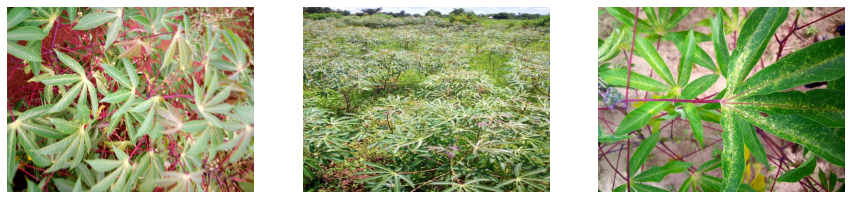

In [73]:
sample = df_train[df_train.label == 2].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()


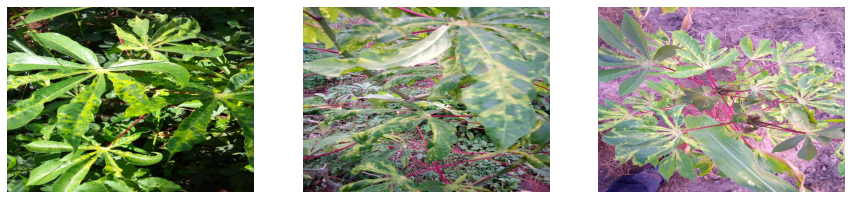

In [75]:
sample = df_train[df_train.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

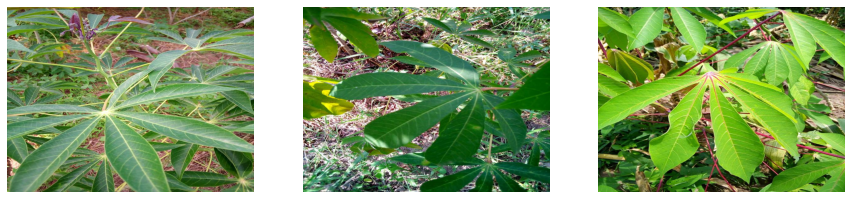

In [76]:
sample = df_train[df_train.label == 4].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

In [113]:
# Main parameters
BATCH_SIZE = 8
STEPS_PER_EPOCH = len(df_train)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(df_train)*0.2 / BATCH_SIZE
EPOCHS = 1
TARGET_SIZE = 512

In [88]:
df_train.label = df_train.label.astype('str')

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(df_train,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")


validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(df_train,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [118]:
def create_model():
    conv_base = EfficientNetB0(include_top = False, weights = None,
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ['accuracy', 'mse'])
    return model

In [98]:
model.save('./basic_EfNetB0_imagenet_512.h5')

In [97]:
model = create_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 512, 512, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 512, 512, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization_2[0][0]            
_______________________________________________________________________________________

In [104]:
print('Our EfficientNet CNN has %d layers' %len(model.layers))

Our EfficientNet CNN has 239 layers


In [119]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [early_stop, reduce_lr]
)



   3/2139 [..............................] - ETA: 4:31:32 - loss: 7.1400 - mae: 2.5000

KeyboardInterrupt: 